In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def show(txt, img):
  print(txt)
  cv2_imshow(img)

In [ ]:
#二值化
def grayscale(image):
  image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image_g

origin


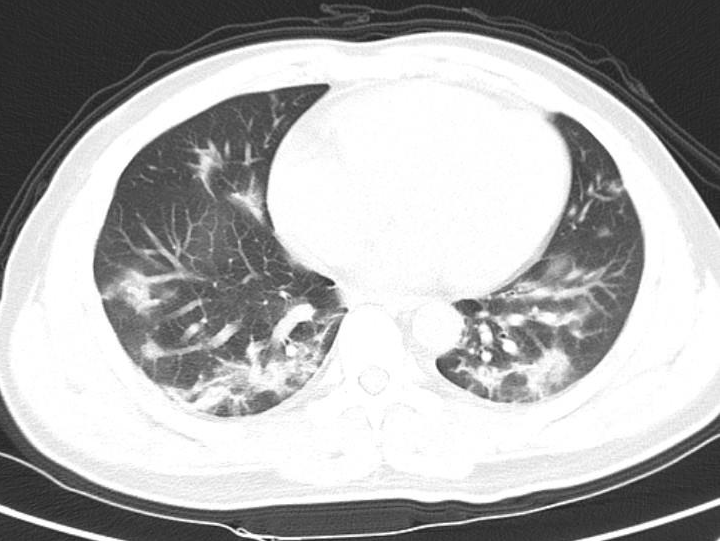

In [ ]:
img=cv2.imread("img.png")
show("origin",img)

grayscale


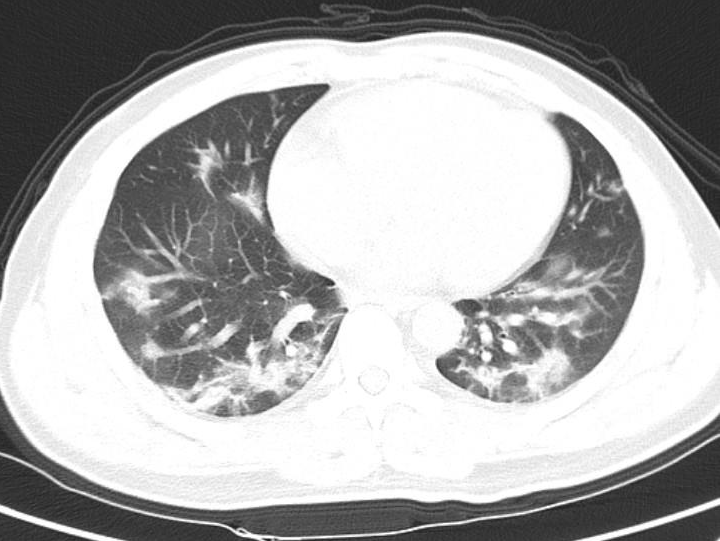

In [ ]:
img_gray=grayscale(img)
show("grayscale",img_gray)

# 直方圖等化Histogram Equalization

In [ ]:
#Histogram Equalization
def HE(image): #直方圖等化
  eqimg=cv2.equalizeHist(image) #使用cv2.equalizeHist
  return eqimg

Histogram


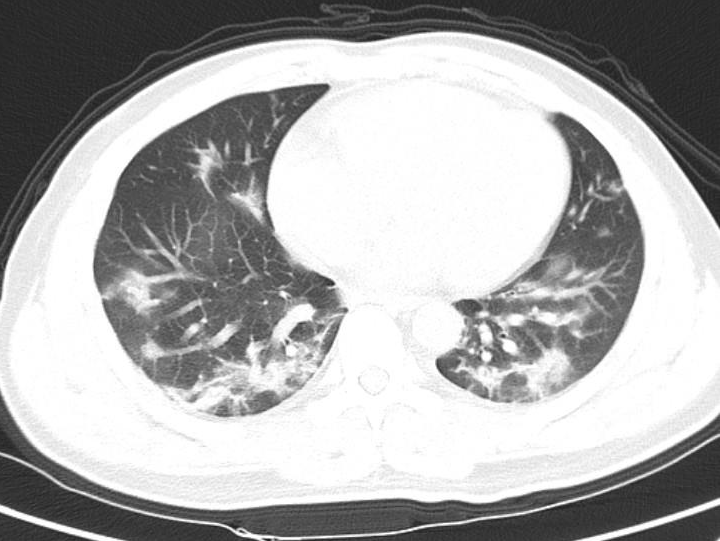

In [ ]:
img_HE=HE(img_gray)
show("Histogram",img_gray)

中值濾波

In [ ]:
#中值濾波
def Medium_filter(img_gray):
  ksize =3#指定尺寸
  img_med=cv2.medianBlur(img_gray,ksize)#影像平滑模糊化
  return img_med

In [ ]:
#Laplacian of Gaussian
def LOG_filter(img_gray):
  ksize= 3#指定尺寸
  ddepth=cv2.CV_64F
  blur = cv2.GaussianBlur(img_gray,(ksize,ksize),0,0)#高斯模糊過濾器
  laplacian =cv2.Laplacian(blur,cv2.CV_64F,ksize= 3)#拉普拉斯過濾
  img_log =laplacian
  return img_log

In [ ]:
#均值濾波
import cv2
def Average_filter(img_gray):#平均濾波
  ksize = 3#指定尺寸
  img_avg =cv2.blur(img_gray,(ksize,ksize))#影像平滑模糊化
  return img_avg

Medium_filter


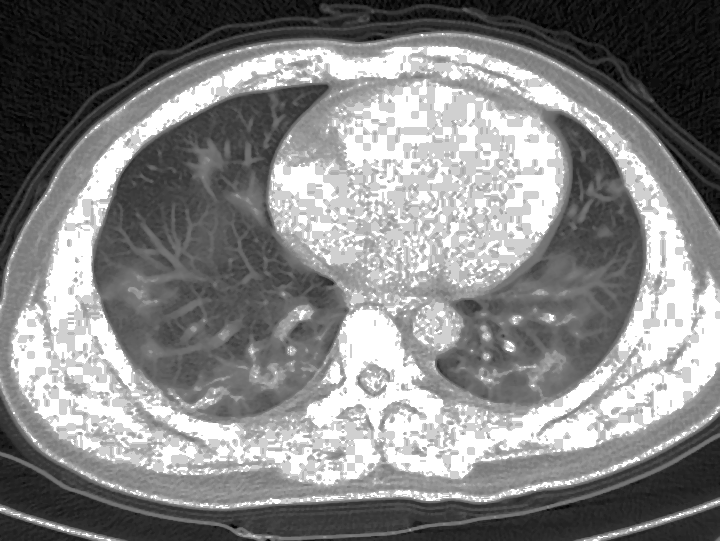

In [ ]:
img_med_filt=Medium_filter(img_HE)
show("Medium_filter",img_med_filt)

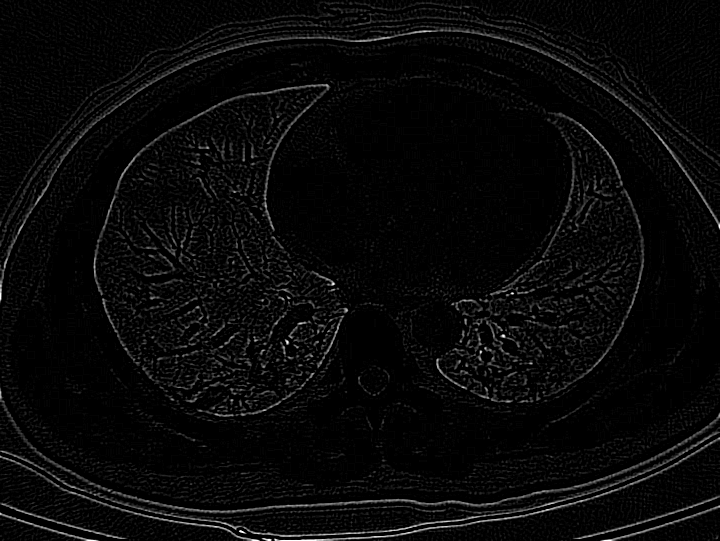

In [ ]:
cv2_imshow(LOG_filter(img_gray))

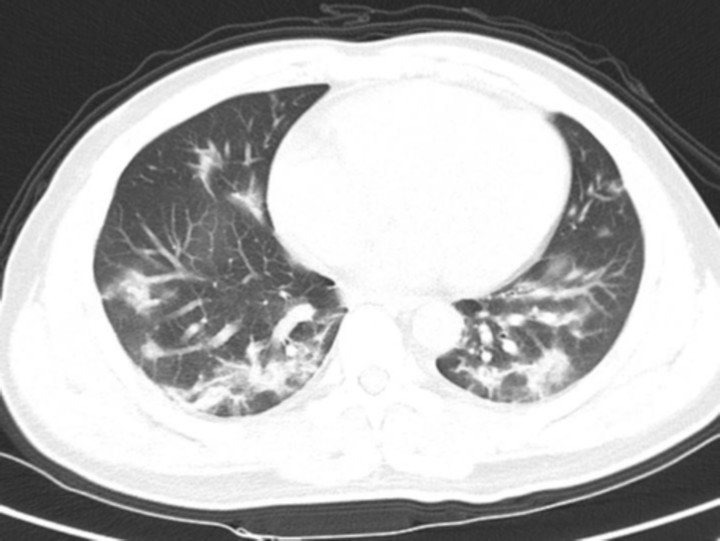

In [ ]:
cv2_imshow(Average_filter(img_gray))

llf

In [ ]:
import cv2 as cv
import numpy as np 
import math
import scipy
def llf(I,sigma,fact,N):
    (height,width)=I.shape
    n_levels=math.ceil(math.log(min(height,width))-math.log(2))+2
    discretisation=np.linspace(0,1,N)
    discretisation_step=discretisation[1]
    input_gaussian_pyr=gaussian_pyramid(I,n_levels,None)
    output_laplace_pyr=laplacian_pyramid(np.zeros((height,width)),n_levels,None)
    output_laplace_pyr[n_levels-1]=input_gaussian_pyr[n_levels-1]
    for ref in discretisation:
        I_remap=fact*(I-ref)*np.exp(-(I-ref)*(I-ref)/(2*sigma*sigma))
        temp_laplace=laplacian_pyramid(I_remap,n_levels,None)
        for level in range(0,n_levels-1):        
            output_laplace_pyr[level]=output_laplace_pyr[level]+((np.abs(input_gaussian_pyr[level]-ref) < discretisation_step))*temp_laplace[level]*(1-np.abs(input_gaussian_pyr[level]-ref)/discretisation_step)

    F=reconstruct_laplacian_pyramid(output_laplace_pyr,None)
    return F
def xllf(I1,I2,sigma,fact,N):
    (height,width)=I1.shape
    n_levels=math.ceil(math.log(min(height,width))-math.log(2))+2
    discretisation=np.linspace(0,1,N)
    discretisation_step=discretisation[1]
    input_gaussian_pyr=gaussian_pyramid(I2,n_levels,None)
    output_laplace_pyr=laplacian_pyramid(np.zeros((height,width)),n_levels,None)
    output_laplace_pyr[n_levels-1]=input_gaussian_pyr[n_levels-1]
    for ref in discretisation:
        I_remap=I1+fact*(I1-ref)*np.exp(-(I2-ref)*(I2-ref)/(2*sigma*sigma))
        temp_laplace=laplacian_pyramid(I_remap,n_levels,None)
        for level in range(0,n_levels-1):        
            output_laplace_pyr[level]=output_laplace_pyr[level]+((np.abs(input_gaussian_pyr[level]-ref) < discretisation_step))*temp_laplace[level]*(1-np.abs(input_gaussian_pyr[level]-ref)/discretisation_step)

    F=reconstruct_laplacian_pyramid(output_laplace_pyr,None)
    return F
def gaussian_pyramid(I,nlev,subwindow):
    (r,c)=I.shape
    if subwindow is None:
        subwindow=[0,r,0,c]
    if nlev is None:
        nlev=numlevels([r,c])    
    pyr=np.empty((nlev),dtype=object)
    pyr[0]=I
    fil=pyramid_filter()
    for i in range(1,nlev):
        I,sub=downsample(I,fil)
        pyr[i]=I
    return pyr
def numlevels(im_sz):
    min_d=min(im_sz)
    nlev=1
    while min_d>1:
        nlev=nlev+1
        min_d=(min_d+1)//2
    return nlev
def child_windows(parent,N=1):
    if N is None:
        N=1
    child =np.array(parent)
    for k in range(N):
        child = (child)/2
        child[0]=math.ceil(child[0])
        child[2]=math.ceil(child[2])
        child[1]=math.floor(child[1])
        child[3]=math.floor(child[3])

    return child
def downsample(I,filter):    
    r,c=I.shape    
    subwindow=[0, r ,0 ,c]
    subwindow_child=child_windows(subwindow)    
    R=cv.filter2D(I,-1,filter,borderType=cv.BORDER_CONSTANT)
    Z=cv.filter2D(np.float32(np.ones(I.shape)),-1,filter,borderType=cv.BORDER_CONSTANT)
    R=R/Z
    reven=(subwindow[0]%2==0)*1
    ceven=(subwindow[2]%2==0)*1
    row=np.arange(0+reven,r,2)
    col=np.arange(0+ceven,c,2)
    R=R[row][:]
    R=R[:,col]
    
    return (R,subwindow_child)
def pyramid_filter():
    f=np.asmatrix(np.array([0.05, 0.25, 0.4, 0.25, 0.05])).T
    f=f.dot(f.T)
    return f
def laplacian_pyramid(I,nlev,subwindow):
    (r,c)=I.shape
    if subwindow is None:
        subwindow=np.array([0,r,0,c])*1.0
    if nlev is None:
        nlev=numlevels([r,c])-1
    pyr=np.empty((nlev),dtype=object)
    fil=pyramid_filter()
    J=I
    for l in range(0,nlev-1):  
        
        (I,subwindow_child)=downsample(I,fil)        
        up=upsample(I,fil,subwindow)
        pyr[l]=J-up
        J=I
        subwindow=subwindow_child
    pyr[nlev-1]=J
    return pyr
def upsample(I,fil,subwindow):
    r=subwindow[1]-subwindow[0]
    c=subwindow[3]-subwindow[2]
    #k=size(I,3)
    reven=(subwindow[0]%2==0)*1
    ceven=(subwindow[2]%2==0)*1
    R=0
    R=np.zeros((int(r),int(c)))
    row=np.arange(0+reven,r,2)
    col=np.arange(0+ceven,c,2)     
    col_c,row_r,=np.meshgrid(col,row) 
    
    R[row_r.astype(int),col_c.astype(int)]=I
    R=cv.filter2D(R,-1,fil,anchor=(-1,-1),borderType=cv.BORDER_CONSTANT)
    Z=np.zeros((int(r),int(c)))        
    Z[row_r.astype(int),col_c.astype(int)]=np.ones(I.shape)
    Z=cv.filter2D(Z,-1,fil,borderType=cv.BORDER_CONSTANT)
    R=R/Z
    
    return R
def reconstruct_laplacian_pyramid(pyr,subwindow):
    (r,c)=pyr[0].shape
    nlev=pyr.size
    
    subwindow_all=np.zeros((nlev,4))
    if subwindow is None:
        subwindow_all[0,:]=[0,r,0,c]
        
    else:
        subwindow_all[1,:]=subwindow
    for lev in range(1,nlev):
        subwindow_all[lev,:]=child_windows(subwindow_all[lev-1,:])
    
    R=pyr[nlev-1]    
    fil=pyramid_filter()
    for lev in range(nlev-2,-1,-1):        
        R=pyr[lev]+upsample(R,fil,subwindow_all[lev,:])
    return R
def repeat(I):
    (r,c)=I.shape
    m=np.zeros((r,c,3))
    m[:,:,0]=I
    m[:,:,1]=I
    m[:,:,2]=I
    return m


(541, 720)
(541, 720)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.25110626220703125


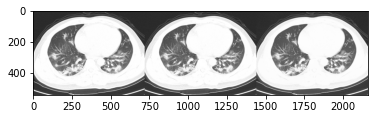

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

# im1= cv.imread('Images\LennaBL.tif')
# im2= cv.imread('Images\LennaBW.tif')
I1=np.float32(cv.cvtColor(img,cv.COLOR_BGR2GRAY)/255)
I2=np.float32(cv.cvtColor(img,cv.COLOR_BGR2GRAY)/255)

sigma=0.1
N=4
fact=-0.75
t = time.time()
#Filtering
print(I1.shape)
print(I2.shape)
im_e=xllf(I1,I2,sigma,fact,N)
im_ergb=repeat(im_e)
elapsed = time.time() - t
print(elapsed)
#plot the image
im_con=np.concatenate((img/255,img/255,im_ergb),axis=1)
imgplt=plt.imshow(im_con)

plt.show()